In [ ]:
import json
import librosa
from sklearn.model_selection import train_test_split
import torch
import librosa.display
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, audio_files, annotations, sr=22050, n_mels=64, hop_length=512, max_len=2000, root_path = 'audios'):
        self.audio_files = audio_files
        self.annotations = annotations
        self.sr = sr
        self.n_mels = n_mels
        self.hop_length = hop_length
        self.max_len = max_len
        self.root_path = root_path

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        audio_path = os.path.join(self.root_path, audio_file)
        y, _ = librosa.load(audio_path, sr=self.sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels, hop_length=self.hop_length)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize the spectogram
        mel_spec = (mel_spec - mel_spec.mean()) / mel_spec.std()

        # Get labels from annotations
        timestamps = self.annotations[audio_file]
        labels = np.zeros(mel_spec.shape[1])  # Initialize labels for each frame
        for start, end in timestamps:
            start_idx = int(start * self.sr / self.hop_length)
            end_idx = int(end * self.sr / self.hop_length)
            labels[start_idx:end_idx] = 1  # Mark frames as "cheering"

        # Pad or trim spectrogram and labels
        if mel_spec.shape[1] > self.max_len:
            mel_spec = mel_spec[:, :self.max_len]
            labels = labels[:self.max_len]
        else:
            pad_width = self.max_len - mel_spec.shape[1]
            mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
            labels = np.pad(labels, (0, pad_width), mode='constant')

        return torch.tensor(mel_spec, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)


In [213]:
# 2. Define the LSTM Model
class LSTMSoundClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMSoundClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, time, features)
        out, _ = self.lstm(x)
        out = self.fc(out)
        return self.sigmoid(out)

In [ ]:
# 4. Post-processing to extract timestamps
def extract_timestamps(predictions, hop_length, sr, merge_threshold = 2, duration_threshold = 1):
    timestamps = []
    start = None
    for i, pred in enumerate(predictions):
        if pred > 0.5 and start is None:
            start = i
        elif pred <= 0.5 and start is not None:
            end = i
            timestamps.append((start * hop_length / sr, end * hop_length / sr))
            start = None
    if start is not None:
        timestamps.append((start * hop_length / sr, len(predictions) * hop_length / sr))
    
    merged_timestamps = []
    for ts in timestamps:
        if not merged_timestamps or ts[0] - merged_timestamps[-1][1] > merge_threshold:
            merged_timestamps.append(ts)
        else:
            merged_timestamps[-1] = (merged_timestamps[-1][0], ts[1])
    
    for ts in merged_timestamps:
        if ts[1] - ts[0] < duration_threshold:
            merged_timestamps.remove(ts)
    return merged_timestamps

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        total_train_loss = 0
        train_correct_predictions = 0
        train_total_samples = 0

        # with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs} - Training") as pbar:
        for mel_spec, labels in train_loader:
            # mel_spec, labels = mel_spec.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(mel_spec) 
            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step() 

            total_train_loss += loss.item()

            predictions = (outputs.squeeze() > 0.5).float()
            train_correct_predictions += (predictions == labels).sum().item()
            train_total_samples += labels.numel()

            # Update the progress bar
            # pbar.set_postfix(loss=f"{loss.item():.4f}")
            # pbar.update(1)

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = train_correct_predictions / train_total_samples

        model.eval() 
        total_val_loss = 0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for mel_spec, labels in val_loader:
                # mel_spec, labels = mel_spec.cuda(), labels.cuda()

                outputs = model(mel_spec)
                loss = criterion(outputs.squeeze(), labels.squeeze())
                total_val_loss += loss.item()

                predictions = (outputs.squeeze() > 0.5).float()
                val_correct_predictions += (predictions == labels).sum().item()
                val_total_samples += labels.numel()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_samples

        print(f"Epoch {epoch+1}/{epochs} -> "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4%}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4%}")

In [223]:
# Load JSON annotations
with open("annotations.json", "r") as f:
    annotations = json.load(f)

# Audio files list
audio_files = list(annotations.keys())

# Split dataset into training and validation subsets
train_files, val_files = train_test_split(audio_files, test_size=0.2, random_state=42)
train_dataset = AudioDataset(train_files, annotations)
val_dataset = AudioDataset(val_files, annotations)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Initialize Model, Loss, Optimizer
model = LSTMSoundClassifier(input_size=64, hidden_size=128, num_layers=2, output_size=1)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Train Model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)



Epoch 1/15 -> Train Loss: 0.6512, Train Accuracy: 75.1562%, Val Loss: 0.5700, Val Accuracy: 82.7667%
Epoch 2/15 -> Train Loss: 0.5329, Train Accuracy: 81.4729%, Val Loss: 0.4786, Val Accuracy: 84.1917%
Epoch 3/15 -> Train Loss: 0.4217, Train Accuracy: 85.9104%, Val Loss: 0.4900, Val Accuracy: 77.0667%
Epoch 4/15 -> Train Loss: 0.3745, Train Accuracy: 86.6333%, Val Loss: 0.3262, Val Accuracy: 84.4667%
Epoch 5/15 -> Train Loss: 0.3353, Train Accuracy: 87.5917%, Val Loss: 0.3021, Val Accuracy: 85.2833%
Epoch 6/15 -> Train Loss: 0.3117, Train Accuracy: 87.7042%, Val Loss: 0.2879, Val Accuracy: 85.5750%
Epoch 7/15 -> Train Loss: 0.3106, Train Accuracy: 87.1562%, Val Loss: 0.2933, Val Accuracy: 84.1500%
Epoch 8/15 -> Train Loss: 0.2832, Train Accuracy: 88.7208%, Val Loss: 0.2846, Val Accuracy: 84.6000%
Epoch 9/15 -> Train Loss: 0.2769, Train Accuracy: 88.7750%, Val Loss: 0.2967, Val Accuracy: 82.7917%
Epoch 10/15 -> Train Loss: 0.2677, Train Accuracy: 89.5312%, Val Loss: 0.2805, Val Accuracy

In [230]:
torch.save(model.state_dict(), 'model.pth')

In [227]:

y, sample_rate = librosa.load('audios/audio23.mp3', sr=22050, mono=True)
hop_length = 512
mel_spec = librosa.feature.melspectrogram(y=y, sr=22050, n_mels=64, hop_length=hop_length)
mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
mel_spec = (mel_spec - mel_spec.mean()) / mel_spec.std()

In [228]:
print(mel_spec.shape)

(64, 1839)


In [229]:
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Predict and extract timestamps
# model.eval()
# print(mel_spec.shape)
# for mel_spec, _ in dataloader:
mel_spec = torch.tensor(mel_spec, dtype=torch.float32)
mel_spec = mel_spec.unsqueeze(0)
print(mel_spec.shape)
with torch.no_grad():
    predictions = model(mel_spec).squeeze().cpu().numpy()
    print('predictions: ', predictions.shape)
timestamps = extract_timestamps(predictions, hop_length=512, sr=22050, merge_threshold=3)
print(timestamps)
    # print(predictions)

torch.Size([1, 64, 1839])
predictions:  (1839,)
[(12.30657596371882, 30.06984126984127), (33.32063492063492, 38.61478458049886)]


In [134]:
mel_spec.shape

(64, 2910)

In [72]:

# Get labels from annotations
timestamps = annotations['audio1.wav']
print(timestamps)
labels = np.zeros(mel_spec.shape[1])  # Initialize labels for each frame
for start, end in timestamps:
    start_idx = int(start * sample_rate / hop_length)
    end_idx = int(end * sample_rate/ hop_length)
    labels[start_idx:end_idx] = 1  # Mark frames as "cheering"

print(labels)
# print(torch.tensor(mel_spec, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32))

[[1.2, 5.0], [10.0, 15.3]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

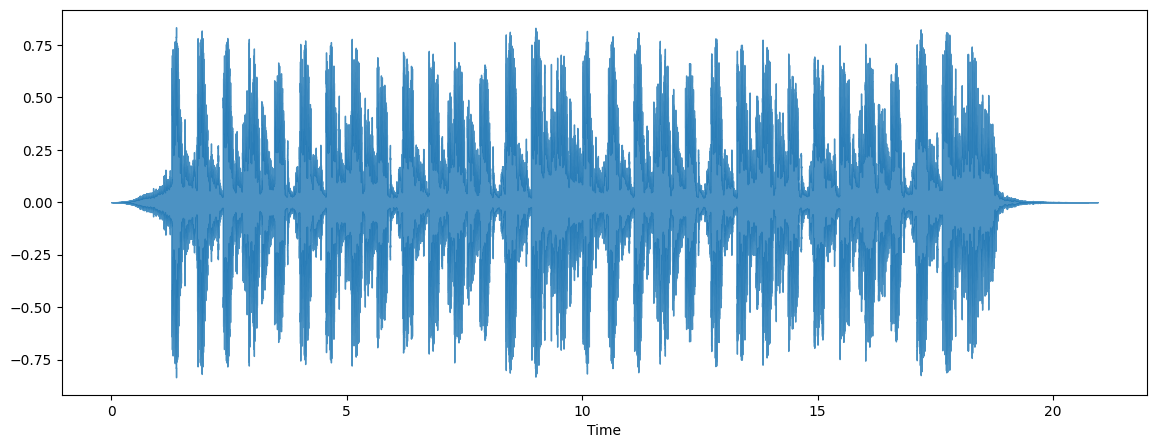

In [30]:
plt.figure(figsize=(14,5))
librosa.display.waveshow(y, sr=sample_rate, alpha=0.8)  # Display waveform
